# Train pipeline for turbulence video stabilisation

In [1]:
import numpy as np
import cv2
import torch

import random
from matplotlib import pyplot as plt

import pathlib

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections.abc import Iterable

import os

from dataclasses import dataclass

plt.rcParams["animation.html"] = "jshtml"


### Data preparation

In [2]:
from pathlib import Path
from typing import Literal


class PairedVideoReader:
    """
    Must be synchronized (same length and corresponding indices).
    """

    def __init__(self, clean_path: str | Path, turb_path: str | Path):
        self.clean_path = clean_path
        self.turb_path = turb_path

        self.clean_cap = cv2.VideoCapture(clean_path)
        self.turb_cap = cv2.VideoCapture(turb_path)
        if not self.clean_cap.isOpened():
            raise FileNotFoundError(f"Cannot open clean video: {clean_path}")
        if not self.turb_cap.isOpened():
            raise FileNotFoundError(f"Cannot open turb video: {turb_path}")

        n1 = int(self.clean_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        n2 = int(self.turb_cap.get(propId=cv2.CAP_PROP_FRAME_COUNT))
        self.length = min(n1, n2)

    def __len__(self) -> int:
        return self.length

    def read_frame(self, idx: int, which: Literal["clean", "turbulent"]) -> np.ndarray:
        if idx < 0 or idx >= self.length:
            raise IndexError(idx)

        cap = self.clean_cap if which == "clean" else self.turb_cap
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ok, img_bgr = cap.read()
        if not ok or img_bgr is None:
            raise RuntimeError(f"Failed to read frame {idx} from {which} video")

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return img_rgb

    def size(self) -> int:
        f1 = self.read_frame(0, "clean")
        f2 = self.read_frame(idx=0, which="turbulent")

        return self.length * (f1.size + f2.size)

In [3]:
class TurbPairDataset(Dataset):
    """
    Samples windows of 5 turb frames -> predicts clean center frame.
    Trains on random patches.
    """

    def __init__(
        self,
        clean_path: str | Path,
        turb_path: str | Path,
        window: int = 5,
        patch: int = 256,
        samples_per_epoch: int = 2000,
        seed: int = 0,
    ):
        super().__init__()
        if window % 2 == 0:
            raise ValueError("window must be odd (e.g. 5)")
        clean_videos = pathlib.Path(clean_path).glob("*.mp4")
        turbulent_videos = pathlib.Path(turb_path).glob("*.mp4")

        clean_videos_map = {path.name: path for path in clean_videos}
        turbulent_videos_map = {path.name: path for path in turbulent_videos}

        dataset_files = [
            (clean_videos_map[key], turbulent_videos_map[key])
            for key in clean_videos_map.keys() & turbulent_videos_map.keys()
        ]

        self.readers = [
            PairedVideoReader(clean_path, turb_path)
            for clean_path, turb_path in dataset_files
        ]
        self.window = window
        self.half = window // 2
        self.patch = patch
        self.samples_per_epoch = samples_per_epoch
        self.rng = random.Random(seed)

        self.valid_centers: list[list[int]] = []
        self.readers_lengths: list[int] = [len(r) for r in self.readers]

        for i, reader in enumerate(self.readers):
            # define valid center indices
            valid_centers = list(range(self.half, len(reader) - self.half))
            if not valid_centers:
                raise ValueError("Not enough frames for the chosen window")
            self.valid_centers.append(valid_centers)
            # probe size
            probe = reader.read_frame(valid_centers[0], "clean")
            self.H, self.W = probe.shape[0], probe.shape[1]

            if patch > self.H or patch > self.W:
                raise ValueError(f"patch {patch} bigger than frame {(self.H, self.W)}")

    def __len__(self) -> int:
        # make epoch length independent of video length
        return self.samples_per_epoch

    def __getitem__(self, _i: int):
        r_i = self.rng.randint(0, len(self.readers) - 1)
        c = self.rng.choice(self.valid_centers[r_i])
        reader = self.readers[r_i]

        # read n turb frames
        turb_frames = []
        for t in range(c - self.half, c + self.half + 1):
            turb_frames.append(reader.read_frame(t, "turbulent"))
        clean = reader.read_frame(c, "clean")

        # random crop patch (same crop applied to all)
        y0 = self.rng.randint(0, self.H - self.patch)
        x0 = self.rng.randint(0, self.W - self.patch)

        turb_frames = [
            f[y0 : y0 + self.patch, x0 : x0 + self.patch] for f in turb_frames
        ]
        clean = clean[y0 : y0 + self.patch, x0 : x0 + self.patch]

        # to torch: [0..1], shapes: (T,C,H,W) and (C,H,W)
        turb = np.stack(turb_frames, axis=0)  # T,H,W,C
        turb = torch.from_numpy(turb).permute(0, 3, 1, 2).float() / 255.0  # T,C,H,W
        clean = torch.from_numpy(clean).permute(2, 0, 1).float() / 255.0  # C,H,W

        return turb, clean


In [4]:
test_dataset = TurbPairDataset(
    clean_path="../data/videos/clean/",
    turb_path="../data/videos/synthetic_turbulence",
    window=31,
)

In [5]:
n_turb, clean = test_dataset[0]

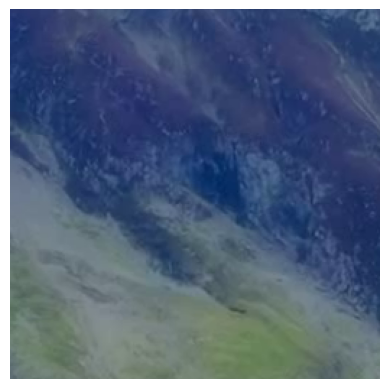

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
im = ax.imshow(n_turb[0].permute(1, 2, 0))
ax.axis("off")


def update(i):
    im.set_data(n_turb[i].permute(1, 2, 0))
    return [im]


ani = FuncAnimation(fig, update, frames=len(n_turb), interval=33, blit=True)
HTML(ani.to_jshtml())

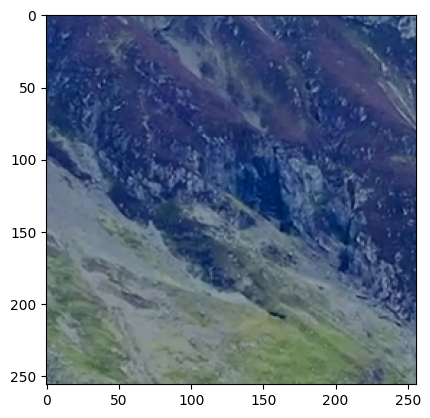

In [7]:
plt.imshow(clean.permute(1, 2, 0))

In [8]:
# -------------------------
# Model (Conv3D -> 2D decoder)
# -------------------------
def conv3d(in_ch, out_ch, k=3, s=(1, 1, 1), p=1, groups=1):
    return nn.Conv3d(in_ch, out_ch, k, stride=s, padding=p, groups=groups, bias=False)


def conv2d(in_ch, out_ch, k=3, s=1, p=1, groups=1):
    return nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, groups=groups, bias=False)


class ResBlock3D(nn.Module):
    def __init__(self, ch: int):
        super().__init__()
        self.n1 = nn.GroupNorm(8, ch)
        self.c1 = conv3d(ch, ch, 3, (1, 1, 1), 1)
        self.n2 = nn.GroupNorm(8, ch)
        self.c2 = conv3d(ch, ch, 3, (1, 1, 1), 1)

    def forward(self, x):
        h = self.c1(F.silu(self.n1(x)))
        h = self.c2(F.silu(self.n2(h)))
        return x + h


class Down3D(nn.Module):
    """Downsample only H,W. Keep T."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = conv3d(in_ch, out_ch, 3, (1, 2, 2), 1)
        self.rb = ResBlock3D(out_ch)

    def forward(self, x):
        return self.rb(self.conv(x))


class ResBlock2D(nn.Module):
    def __init__(self, ch: int):
        super().__init__()
        self.n1 = nn.GroupNorm(8, ch)
        self.c1 = conv2d(ch, ch, 3, 1, 1)
        self.n2 = nn.GroupNorm(8, ch)
        self.c2 = conv2d(ch, ch, 3, 1, 1)

    def forward(self, x):
        h = self.c1(F.silu(self.n1(x)))
        h = self.c2(F.silu(self.n2(h)))
        return x + h


class Up2D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = conv2d(in_ch, out_ch, 3, 1, 1)
        self.rb = ResBlock2D(out_ch)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False)
        x = self.conv(x)
        x = self.rb(x)
        return x


class TemporalAttnPool(nn.Module):
    """x: B,C,T,H,W -> B,C,H,W (attention over T per-pixel)"""

    def __init__(self, ch: int):
        super().__init__()
        self.to_q = nn.Conv3d(ch, ch, 1, bias=False)
        self.to_k = nn.Conv3d(ch, ch, 1, bias=False)
        self.to_v = nn.Conv3d(ch, ch, 1, bias=False)
        self.scale = ch**-0.5

    def forward(self, x):
        q = self.to_q(x)
        k = self.to_k(x)
        v = self.to_v(x)
        scores = (q * k).sum(dim=1) * self.scale  # B,T,H,W
        w = torch.softmax(scores, dim=1)
        y = (v * w.unsqueeze(1)).sum(dim=2)  # B,C,H,W
        return y


class TurbRestore3D(nn.Module):
    """Input: B,T=5,C=3,H,W -> Output: B,3,H,W"""

    def __init__(self, base_ch=48, out_ch=3):
        super().__init__()
        self.stem = nn.Sequential(
            conv3d(3, base_ch, 3, (1, 1, 1), 1),
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            ResBlock3D(base_ch),
        )
        self.down1 = Down3D(base_ch, base_ch * 2)  # /2
        self.down2 = Down3D(base_ch * 2, base_ch * 4)  # /4
        self.down3 = Down3D(base_ch * 4, base_ch * 6)  # /8

        self.mid = nn.Sequential(
            ResBlock3D(base_ch * 6),
            ResBlock3D(base_ch * 6),
        )

        self.pool3 = TemporalAttnPool(base_ch * 6)
        self.pool2 = TemporalAttnPool(base_ch * 4)
        self.pool1 = TemporalAttnPool(base_ch * 2)
        self.pool0 = TemporalAttnPool(base_ch)

        # decoder: upsample THEN concat with same-scale skip
        self.up3_to2 = Up2D(base_ch * 6, base_ch * 4)  # /8 -> /4
        self.fuse2 = nn.Sequential(
            conv2d(base_ch * 4 + base_ch * 4, base_ch * 4), ResBlock2D(base_ch * 4)
        )

        self.up2_to1 = Up2D(base_ch * 4, base_ch * 2)  # /4 -> /2
        self.fuse1 = nn.Sequential(
            conv2d(base_ch * 2 + base_ch * 2, base_ch * 2), ResBlock2D(base_ch * 2)
        )

        self.up1_to0 = Up2D(base_ch * 2, base_ch)  # /2 -> /1
        self.fuse0 = nn.Sequential(
            conv2d(base_ch + base_ch, base_ch), ResBlock2D(base_ch)
        )

        self.head = nn.Sequential(
            ResBlock2D(base_ch),
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            nn.Conv2d(base_ch, out_ch, 3, padding=1),
        )

    def forward(self, x):
        # x: B,T,C,H,W -> B,C,T,H,W
        x = x.permute(0, 2, 1, 3, 4).contiguous()

        s0 = self.stem(x)  # B,c,  T,H,  W
        s1 = self.down1(s0)  # B,2c, T,H/2,W/2
        s2 = self.down2(s1)  # B,4c, T,H/4,W/4
        s3 = self.down3(s2)  # B,6c, T,H/8,W/8
        m = self.mid(s3)  # B,6c, T,H/8,W/8

        p3 = self.pool3(m)  # B,6c, H/8,W/8
        p2 = self.pool2(s2)  # B,4c, H/4,W/4
        p1 = self.pool1(s1)  # B,2c, H/2,W/2
        p0 = self.pool0(s0)  # B, c, H,  W

        d2 = self.up3_to2(p3)  # -> H/4,W/4
        d2 = self.fuse2(torch.cat([d2, p2], dim=1))

        d1 = self.up2_to1(d2)  # -> H/2,W/2
        d1 = self.fuse1(torch.cat([d1, p1], dim=1))

        d0 = self.up1_to0(d1)  # -> H,W
        d0 = self.fuse0(torch.cat([d0, p0], dim=1))

        return self.head(d0)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv3d(in_ch, out_ch, k=3, s=1, p=1, bias=False):
    return nn.Conv3d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)


def conv2d(in_ch, out_ch, k=3, s=1, p=1, bias=False):
    return nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)


class ResBlock3D(nn.Module):
    def __init__(self, ch: int):
        super().__init__()
        self.n1 = nn.GroupNorm(8, ch)
        self.c1 = conv3d(ch, ch, 3, 1, 1)
        self.n2 = nn.GroupNorm(8, ch)
        self.c2 = conv3d(ch, ch, 3, 1, 1)

    def forward(self, x):
        h = self.c1(F.silu(self.n1(x)))
        h = self.c2(F.silu(self.n2(h)))
        return x + h


class TemporalWeightedPool(nn.Module):
    """
    x: B,C,T,H,W -> B,C,H,W
    Learn per-pixel weights over T.
    """

    def __init__(self, ch: int, T: int):
        super().__init__()
        self.T = T
        # produce logits per time step
        self.logits = nn.Conv3d(ch, 1, kernel_size=1, bias=True)

    def forward(self, x):
        # logits: B,1,T,H,W
        a = self.logits(x)
        w = torch.softmax(a, dim=2)  # over T
        y = (x * w).sum(dim=2)  # B,C,H,W
        return y


class TurbRestore3DPlain(nn.Module):
    """
    Input:  B,T(=5),C(=3),H,W
    Output: B,3,H,W
    No encoder/decoder, constant resolution.
    """

    def __init__(self, base_ch=64, blocks=10, T=5):
        super().__init__()
        self.T = T

        self.stem = nn.Sequential(
            conv3d(3, base_ch, 3, 1, 1),
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
        )

        self.body = nn.Sequential(*[ResBlock3D(base_ch) for _ in range(blocks)])

        self.pool = TemporalWeightedPool(base_ch, T=T)

        self.head = nn.Sequential(
            nn.GroupNorm(8, base_ch),
            nn.SiLU(),
            conv2d(base_ch, base_ch, 3, 1, 1),
            nn.SiLU(),
            conv2d(base_ch, 3, 3, 1, 1, bias=True),
        )

    def forward(self, x):
        # x: B,T,C,H,W -> B,C,T,H,W
        x = x.permute(0, 2, 1, 3, 4).contiguous()

        # central frame for residual (B,3,H,W)
        center = x[:, :, self.T // 2]

        f = self.stem(x)  # B,Ch,T,H,W
        f = self.body(f)  # B,Ch,T,H,W
        f2d = self.pool(f)  # B,Ch,H,W

        out = self.head(f2d)  # B,3,H,W
        return (out + center).clamp(0.0, 1.0)

In [10]:
# -------------------------
# Losses
# -------------------------


def sobel_edges(x: torch.Tensor) -> torch.Tensor:
    """
    x: B,C,H,W
    returns gradient magnitude per-channel
    """
    kx = torch.tensor(
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1],
        ],
        device=x.device,
        dtype=x.dtype,
    ).view(1, 1, 3, 3)
    ky = torch.tensor(
        [
            [-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1],
        ],
        device=x.device,
        dtype=x.dtype,
    ).view(1, 1, 3, 3)
    B, C, H, W = x.shape
    kx = kx.repeat(C, 1, 1, 1)
    ky = ky.repeat(C, 1, 1, 1)
    gx = F.conv2d(x, kx, padding=1, groups=C)
    gy = F.conv2d(x, ky, padding=1, groups=C)
    return torch.sqrt(gx * gx + gy * gy + 1e-6)

In [11]:
# -------------------------
# Train
# -------------------------


@dataclass
class TrainCfg:
    clean_path: str = "../data/videos/clean/"
    turb_path: str = "../data/videos/synthetic_turbulence"
    outdir: str = "runs/turb_restore"
    epochs: int = 20
    steps_per_epoch: int = 2000
    batch_size: int = 8
    patch: int = 256
    lr: float = 2e-4
    window: int = 5
    num_workers: int = 4
    base_ch: int = 48
    seed: int = 0
    device: str = "cuda"
    amp: bool = True
    edge_loss_w: float = 0.05
    l1_w: float = 1.0


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def save_checkpoint(
    path: str, model: nn.Module, optim: torch.optim.Optimizer, epoch: int, step: int
):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(
        {
            "model": model.state_dict(),
            "optim": optim.state_dict(),
            "epoch": epoch,
            "step": step,
        },
        path,
    )

In [12]:
import time
from dataclasses import asdict

import torch
from torch.utils.tensorboard import SummaryWriter
import tqdm


def _to_u8_img(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B,C,H,W) float [0,1] -> (B,C,H,W) uint8 [0,255]
    """
    x = x.detach().clamp(0, 1)
    return (x * 255.0).round().to(torch.uint8)


def _make_grid_4up(
    center: torch.Tensor, pred: torch.Tensor, gt: torch.Tensor
) -> torch.Tensor:
    """
    Returns a single image grid (C, H*2, W*2):
    [center | pred]
    [gt     | absdiff]
    """
    center = center.detach().clamp(0, 1)
    pred = pred.detach().clamp(0, 1)
    gt = gt.detach().clamp(0, 1)
    absdiff = (pred - gt).abs()

    top = torch.cat([center, pred], dim=-1)  # (B,C,H,2W)
    bot = torch.cat([gt, absdiff], dim=-1)  # (B,C,H,2W)
    grid = torch.cat([top, bot], dim=-2)  # (B,C,2H,2W)

    return grid


def train(cfg: TrainCfg):
    set_seed(cfg.seed)
    device = torch.device(cfg.device if torch.cuda.is_available() else "cpu")

    # Data
    ds = TurbPairDataset(
        clean_path=cfg.clean_path,
        turb_path=cfg.turb_path,
        window=cfg.window,
        patch=cfg.patch,
        samples_per_epoch=cfg.steps_per_epoch,
        seed=cfg.seed,
    )
    dl = DataLoader(
        ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        # num_workers=getattr(cfg, "num_workers", 0),
        # pin_memory=(device.type == "cuda"),
        # drop_last=True,
        # persistent_workers=(getattr(cfg, "num_workers", 0) > 0),
    )

    # Model
    model = TurbRestore3DPlain(base_ch=cfg.base_ch, T=cfg.window).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=1e-4)
    scaler = torch.amp.GradScaler("cuda", enabled=(cfg.amp and device.type == "cuda"))  # type: ignore

    # TensorBoard
    run_id = time.strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(cfg.outdir, "tb", run_id)
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)

    # Save config to TB text (nice)
    try:
        writer.add_text("cfg", "<pre>" + str(asdict(cfg)) + "</pre>", 0)
    except Exception:
        writer.add_text("cfg", "<pre>" + str(cfg) + "</pre>", 0)

    # Log frequency (can add to cfg if you want)
    log_every = getattr(cfg, "log_every", 5)  # scalar logging
    img_every = getattr(cfg, "img_every", 50)  # image logging
    ckpt_every = getattr(cfg, "ckpt_every", 100)  # checkpoint

    os.makedirs(cfg.outdir, exist_ok=True)

    global_step = 0
    model.train()

    try:
        for epoch in range(cfg.epochs):
            pbar = tqdm.tqdm(
                dl, desc=f"epoch {epoch + 1}/{cfg.epochs}", dynamic_ncols=True
            )
            for turb, clean in pbar:
                turb = turb.to(device, non_blocking=True)  # B,T,C,H,W
                clean = clean.to(device, non_blocking=True)  # B,C,H,W

                optim.zero_grad(set_to_none=True)

                with torch.cuda.amp.autocast(
                    enabled=(cfg.amp and device.type == "cuda")
                ):
                    pred = model(turb)  # already clamps inside model, but keep safe:
                    pred = pred.clamp(0.0, 1.0)

                    l1 = F.l1_loss(pred, clean)
                    if cfg.edge_loss_w > 0:
                        e_pred = sobel_edges(pred)
                        e_gt = sobel_edges(clean)
                        edge = F.l1_loss(e_pred, e_gt)
                    else:
                        edge = pred.new_tensor(0.0)

                    loss = cfg.l1_w * l1 + cfg.edge_loss_w * edge

                scaler.scale(loss).backward()

                # grad norm (loggable)
                scaler.unscale_(optim)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                scaler.step(optim)
                scaler.update()

                # update step
                global_step += 1

                # tqdm postfix
                pbar.set_postfix(
                    loss=float(loss.item()),
                    l1=float(l1.item()),
                    edge=float(edge.item()),
                    gn=float(
                        grad_norm.item() if torch.is_tensor(grad_norm) else grad_norm
                    ),
                    lr=float(optim.param_groups[0]["lr"]),
                )

                # --- TensorBoard scalars ---
                if global_step % log_every == 0:
                    writer.add_scalar("train/loss", float(loss.item()), global_step)
                    writer.add_scalar("train/l1", float(l1.item()), global_step)
                    writer.add_scalar("train/edge", float(edge.item()), global_step)
                    writer.add_scalar(
                        "train/lr", float(optim.param_groups[0]["lr"]), global_step
                    )
                    writer.add_scalar(
                        "train/grad_norm",
                        float(
                            grad_norm.item()
                            if torch.is_tensor(grad_norm)
                            else grad_norm
                        ),
                        global_step,
                    )

                # --- TensorBoard images ---
                if global_step % img_every == 0:
                    # Center turb frame (reference)
                    center = turb[:, cfg.window // 2]  # B,C,H,W
                    grid = _make_grid_4up(center, pred, clean)  # B,C,2H,2W

                    # log only first sample to keep TB light
                    img = _to_u8_img(grid[:1])[0]  # C,2H,2W uint8
                    writer.add_image("train/center_pred_gt_absdiff", img, global_step)

                    # Optional: histogram helps debug saturation
                    writer.add_histogram(
                        "train/pred_hist", pred.detach().float().cpu(), global_step
                    )
                    writer.add_histogram(
                        "train/gt_hist", clean.detach().float().cpu(), global_step
                    )

                # --- checkpoints ---
                if global_step % ckpt_every == 0:
                    ckpt_path = os.path.join(cfg.outdir, f"ckpt_step_{global_step}.pt")
                    save_checkpoint(ckpt_path, model, optim, epoch, global_step)
                    writer.add_text("checkpoints/last", ckpt_path, global_step)

            # epoch checkpoint
            ckpt_path = os.path.join(cfg.outdir, f"ckpt_epoch_{epoch + 1}.pt")
            save_checkpoint(ckpt_path, model, optim, epoch, global_step)
            writer.add_text("checkpoints/epoch", ckpt_path, global_step)

    finally:
        writer.flush()
        writer.close()

    print(f"TensorBoard logs: {log_dir}")
    print(f"Run:  tensorboard --logdir {os.path.join(cfg.outdir, 'tb')}")

In [13]:
cfg = TrainCfg(
    clean_path="../data/videos/clean/",
    turb_path="../data/videos/synthetic_turbulence",
    outdir="runs/turb_restore",
    epochs=20,
    steps_per_epoch=2000,
    batch_size=4,
    patch=256,
    lr=2e-4,
    window=5,
    num_workers=4,
    base_ch=48,
    seed=0,
    device="cuda",
    amp=True,
    edge_loss_w=0.05,
    l1_w=1.0,
)

train(cfg)

epoch 1/20:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_685831/2280072864.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(
epoch 1/20:  94%|█████████▍| 471/500 [08:54<00:32,  1.14s/it, edge=0.0705, gn=0.211, l1=0.0186, loss=0.0221, lr=0.0002]  


KeyboardInterrupt: 